Epoch [1/10], Loss: 0.0481


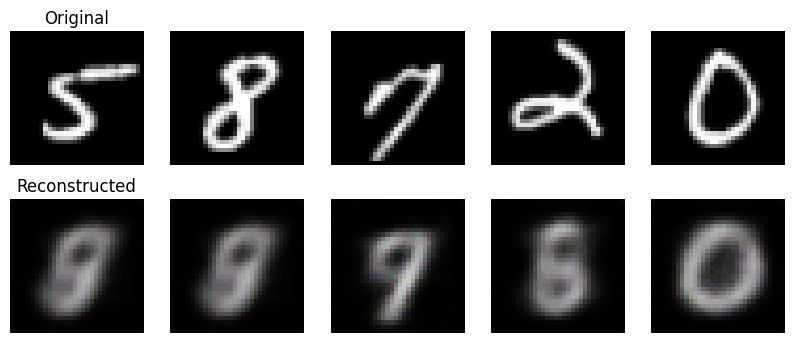

Epoch [2/10], Loss: 0.0507


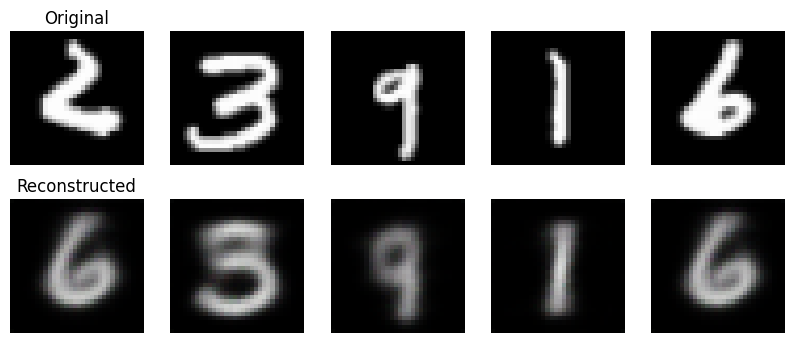

Epoch [3/10], Loss: 0.0525


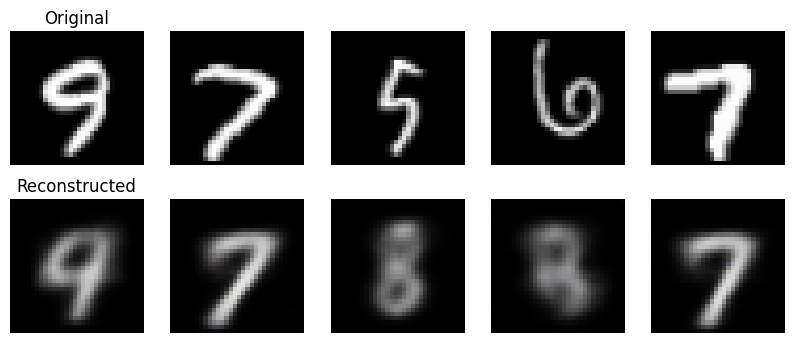

Epoch [4/10], Loss: 0.0424


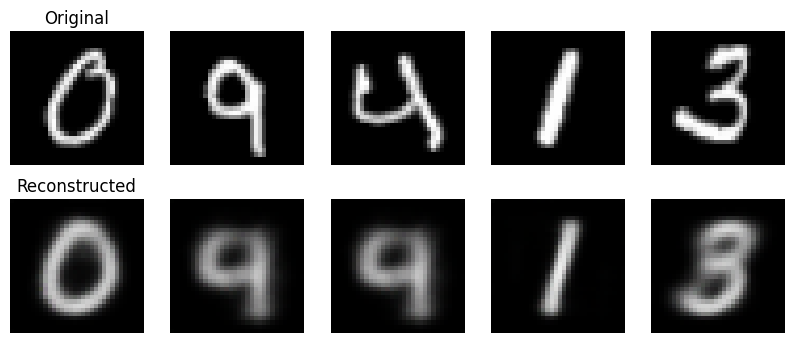

Epoch [5/10], Loss: 0.0477


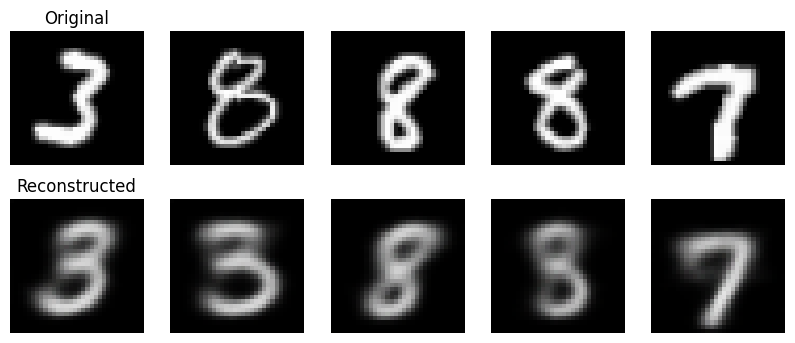

Epoch [6/10], Loss: 0.0522


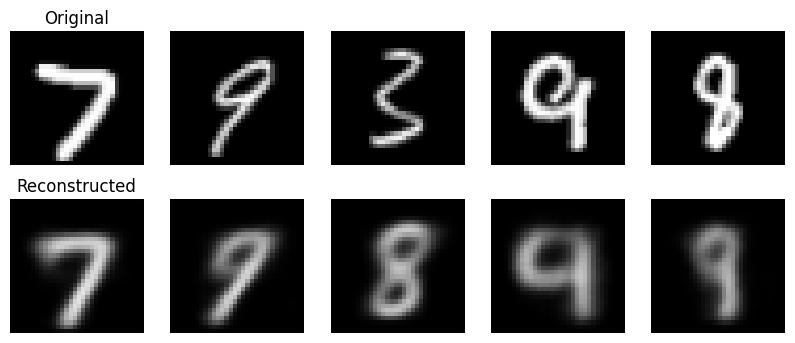

Epoch [7/10], Loss: 0.0568


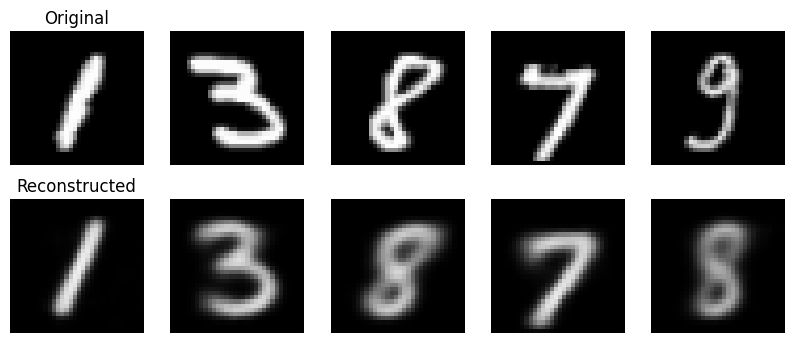

Epoch [8/10], Loss: 0.0464


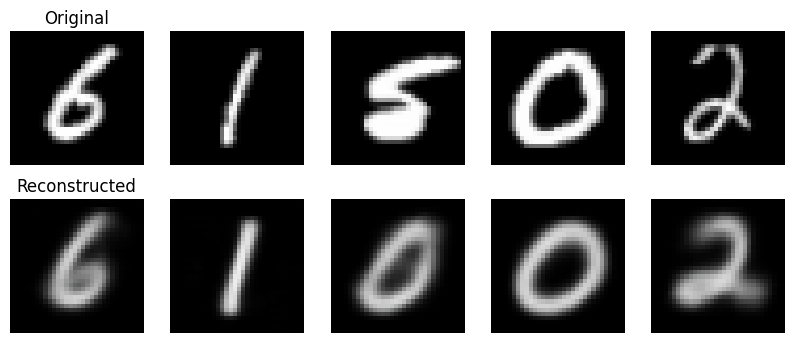

Epoch [9/10], Loss: 0.0503


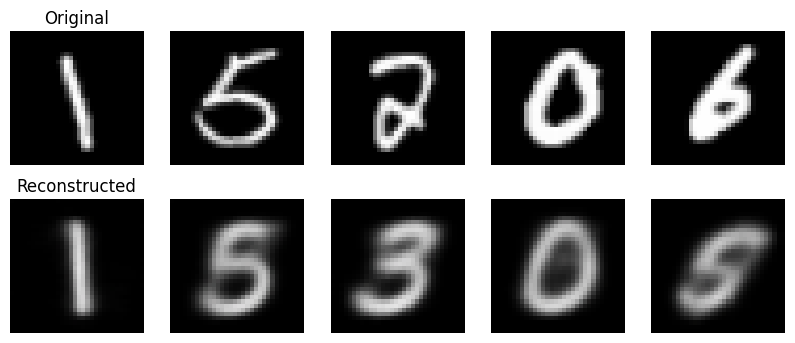

Epoch [10/10], Loss: 0.0413


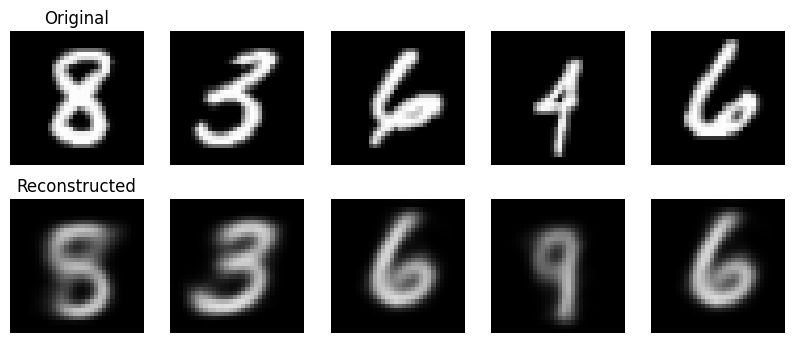

Training finished.


In [8]:
import torch, itertools
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)


class Encoder(nn.Module):
    def __init__(self, input_channels):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),   
        )

    def forward(self, x):
        return self.conv(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv_trans = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),  # Output between 0 and 1
        )

    def forward(self, x):
        return self.conv_trans(x)

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost

        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embedding.weight.data.uniform_(-1 / self.num_embeddings, 1 / self.num_embeddings)

    def forward(self, z):
        z_flattened = z.view(-1, self.embedding_dim)
        d = torch.sum(z_flattened**2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1) - 2 * torch.matmul(z_flattened, self.embedding.weight.t())
        encoding_indices = torch.argmin(d, dim=1).unsqueeze(1)
        z_q = self.embedding(encoding_indices).view(z.shape)
        
        e_latent_loss = F.mse_loss(z_q.detach(), z)
        q_latent_loss = F.mse_loss(z_q, z.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss
        
        z_q = z + (z_q - z).detach()
        return loss, z_q, encoding_indices


fixed_images, _ = next(iter(DataLoader(dataset=train_dataset, batch_size=5, shuffle=True)))
fixed_images = fixed_images.to(device)


input_channels = 3
commitment_cost = 0.25
num_embeddings = 512
embedding_dim = 512

encoder = Encoder(input_channels).to(device)
decoder = Decoder().to(device)
vector_quantizer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost).to(device)

parameters = list(encoder.parameters()) + list(decoder.parameters()) + list(vector_quantizer.parameters())
optimizer = optim.Adam(parameters, lr=0.001)

def reconstruct_images(encoder, decoder, vector_quantizer, data_loader, device, num_images=5):
    encoder.eval()
    decoder.eval()
    vector_quantizer.eval()

    data_iter = iter(data_loader)
    images, _ = next(data_iter)
    images = images.to(device)

    with torch.no_grad():
        encoded = encoder(images)
        _, quantized, _ = vector_quantizer(encoded)
        decoded = decoder(quantized)
    
    # Select first num_images images
    images = images[:num_images].cpu()
    decoded = decoded[:num_images].cpu()

    # Plot original and reconstructed images
    fig, axs = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
    for i in range(num_images):
        axs[0, i].imshow(images[i].permute(1, 2, 0).squeeze(), cmap='gray')
        axs[0, i].axis('off')
        axs[1, i].imshow(decoded[i].permute(1, 2, 0).squeeze(), cmap='gray')
        axs[1, i].axis('off')
    axs[0, 0].set_title('Original')
    axs[1, 0].set_title('Reconstructed')
    plt.show()

    encoder.train()
    decoder.train()
    vector_quantizer.train()


num_epochs = 10
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)

        # Forward pass
        encoded = encoder(img)
        vq_loss, quantized, _ = vector_quantizer(encoded)
        decoded = decoder(quantized)
        
        # Reconstruction loss
        recon_loss = F.mse_loss(decoded, img)
        total_loss = recon_loss + vq_loss

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item():.4f}')

    # Reconstruct and display images after each epoch
    reconstruct_images(encoder, decoder, vector_quantizer, train_loader, device)

print("Training finished.")